In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from pylab import rcParams

%matplotlib inline
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
rcParams['figure.figsize'] = (20,8)


In [5]:
""" At this point we load in the cloud-masked data for a certain geographical extent, and resample 
to 2M frequency (in an attempt to correct for NANs due to patchy clouds and same-day scene overlaps)
"""

%cd /g/data/xc0/project/Burn_Mapping/01_LS_Reflectance_and_Indices/SS
data = xr.open_dataset('Tas2016_Sumac_Forest_reflectance_indices.nc')
data = data.resample(time="M").mean().dropna('time',how='all')

/g/data1a/xc0/project/Burn_Mapping/01_LS_Reflectance_and_Indices/SS


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [6]:
def _forward_fill(Input_DataArray):
    temp_array = Input_DataArray
    
    for i in np.arange(0,len(temp_array.time)):
        temp_array = temp_array.fillna(temp_array.shift(time=1))
    
    return(temp_array)


def _identify_burned_area(Input_DataArray,lag0_threshold, lag1_threshold):
    
    A = _forward_fill(Input_DataArray)
    B1 = A - A.shift(time=1)
    B2 = A.shift(time=-1)-A.shift(time=1)
    
    C = B1.where(B1 < lag0_threshold)
    D = (B1 < lag0_threshold) & (B2 < lag1_threshold)
    
    return D


In [ ]:
### THIS CELL FOR GOAL-SEEKING THE OPTIMAL THRESHOLD VALUE (i.e. the one that maximises the classification accuracy)

%cd /g/data/xc0/user/Ram/Burn Mapping/02 Git/burn-mapping/notebooks/Ram
from CreateValidatedBurnMask import _CreateValidatedBurnMask

accuracy_list = [0,0]

threshold = -0.10

for i in np.arange(-1,0.2,0.05):
    
    threshold=i
    
    data['Classified_Burned'] = _identify_burned_area(data.NBR, threshold , threshold/2 )

    Classified_Burned = data.Classified_Burned.resample(time='AS-JUL').max('time').dropna('time',how='all')
    Classified_Burned.name = 'Classified_Burned'

    Validated_Burned = _CreateValidatedBurnMask(reference_DataArray=data)
    Validated_Burned = Validated_Burned.resample(time='AS-JUL').max('time').dropna('time',how='all')
    Validated_Burned.values[np.isnan(Validated_Burned.values)] = bool(0)
    Validated_Burned = Validated_Burned.astype('bool')
    Validated_Burned.name = 'Validated_Burned'

    Comparison_Dataset = xr.merge((Validated_Burned,Classified_Burned) , join='inner')

    classification_accuracy_df = pd.DataFrame([[0,0],[0,0]])
    classification_accuracy_df.columns = ('Actual_Burned','Actual_Unburned')
    classification_accuracy_df.index = ('Pred_Burned','Pred_Unburned')

    classification_accuracy_df.iloc[0,0] = np.sum((Comparison_Dataset.Validated_Burned == True) & (Comparison_Dataset.Classified_Burned == True))
    classification_accuracy_df.iloc[0,1] = np.sum((Comparison_Dataset.Validated_Burned == True) & (Comparison_Dataset.Classified_Burned == False))
    classification_accuracy_df.iloc[1,0] = np.sum((Comparison_Dataset.Validated_Burned == False) & (Comparison_Dataset.Classified_Burned == True))
    classification_accuracy_df.iloc[1,1] = np.sum((Comparison_Dataset.Validated_Burned == False) & (Comparison_Dataset.Classified_Burned == False))

    #print(classification_accuracy_df)
    
    percentage_accuracy = 100*( classification_accuracy_df.iloc[0,0] + classification_accuracy_df.iloc[1,1] ) / classification_accuracy_df.sum().sum()


    #print ('for threshold = ', i, " - ",'classification accuracy = ' , percentage_accuracy, "%")
    
    accuracy_list = np.concatenate((accuracy_list,[i,percentage_accuracy]), axis=0)

accuracy_list = pd.DataFrame(np.array(accuracy_list).reshape(25,2))
print(accuracy_list)

/g/data1a/xc0/user/Ram/Burn Mapping/02 Git/burn-mapping/notebooks/Ram


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


I am densified (external_values, 7249 elements)


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


I am densified (external_values, 7249 elements)


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


I am densified (external_values, 7249 elements)


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


I am densified (external_values, 7249 elements)


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


I am densified (external_values, 7249 elements)


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


I am densified (external_values, 7249 elements)


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


I am densified (external_values, 7249 elements)


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


I am densified (external_values, 7249 elements)


In [166]:
threshold = -0.35

data['Classified_Burned'] = _identify_burned_area(data.NBR, threshold , threshold/2 )

Classified_Burned = data.Classified_Burned.resample(time='AS-JUL').max('time').dropna('time',how='all')
Classified_Burned.name = 'Classified_Burned'

Validated_Burned = _CreateValidatedBurnMask(reference_DataArray=data)
Validated_Burned = Validated_Burned.resample(time='AS-JUL').max('time').dropna('time',how='all')
Validated_Burned.values[np.isnan(Validated_Burned.values)] = bool(0)
Validated_Burned = Validated_Burned.astype('bool')
Validated_Burned.name = 'Validated_Burned'

Comparison_Dataset = xr.merge((Validated_Burned,Classified_Burned) , join='inner')

classification_accuracy_df = pd.DataFrame([[0,0],[0,0]])
classification_accuracy_df.columns = ('Actual_Burned','Actual_Unburned')
classification_accuracy_df.index = ('Pred_Burned','Pred_Unburned')

classification_accuracy_df.iloc[0,0] = np.sum((Comparison_Dataset.Validated_Burned == True) & (Comparison_Dataset.Classified_Burned == True))
classification_accuracy_df.iloc[0,1] = np.sum((Comparison_Dataset.Validated_Burned == True) & (Comparison_Dataset.Classified_Burned == False))
classification_accuracy_df.iloc[1,0] = np.sum((Comparison_Dataset.Validated_Burned == False) & (Comparison_Dataset.Classified_Burned == True))
classification_accuracy_df.iloc[1,1] = np.sum((Comparison_Dataset.Validated_Burned == False) & (Comparison_Dataset.Classified_Burned == False))

print(classification_accuracy_df)

percentage_accuracy = 100*( classification_accuracy_df.iloc[0,0] + classification_accuracy_df.iloc[1,1] ) / classification_accuracy_df.sum().sum()

print ('for threshold = ', threshold, " - ",'classification accuracy = ' , percentage_accuracy, "%")


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


I am densified (external_values, 7249 elements)
               Actual_Burned  Actual_Unburned
Pred_Burned            46494            25999
Pred_Unburned           6060           715667
for threshold =  0.15  -  classification accuracy =  95.9634610058 %


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


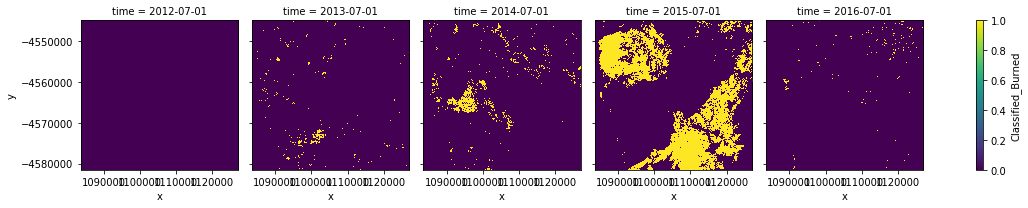

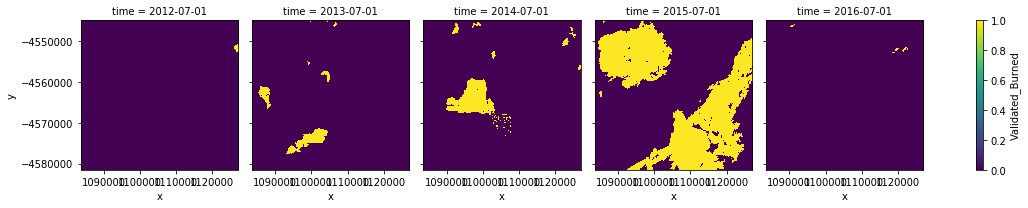

In [167]:
Comparison_Dataset.Classified_Burned.plot.imshow(col='time',col_wrap=5)

Comparison_Dataset.Validated_Burned.plot.imshow(col='time',col_wrap=5)